https://youtu.be/5FpKokShdtw

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.model_selection import train_test_split
import os
import pickle


In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
vis = True

In [3]:
basedir = 'vehicles/'
# different folders respresent different 
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))
print('Number of vehicles images found', len(cars))
with open("cars.txt", "w") as f:
    for fn in cars:
        f.write(fn+'\n')
        
# do the same for non vehicles
basedir = 'non-vehicles/'
# different folders respresent different 
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
print('Number of non-vehicles images found', len(notcars))
with open("notcars.txt", "w") as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of vehicles images found 8792
Number of non-vehicles images found 8968


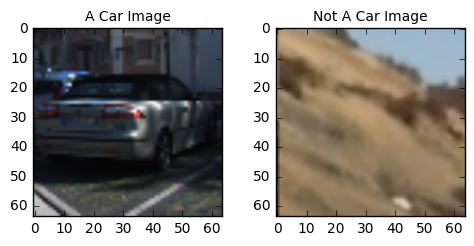

In [4]:
# Generate a random index to look at a car image
ind_cars = np.random.randint(0, len(cars))
car_image = mpimg.imread(cars[ind_cars])

# Generate a random index to look at a notcar image
ind_notcars = np.random.randint(0, len(notcars))
notcar_image = mpimg.imread(notcars[ind_notcars])

# plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize=(5,5))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('A Car Image', fontsize = 10)
ax2.imshow(notcar_image)
ax2.set_title('Not A Car Image', fontsize=10)



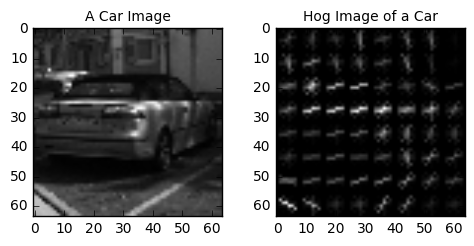

In [7]:
gray_image = car_image[:,:,2]
feature_vector, hog_image = hog(gray_image, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=True, feature_vector=True)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(5,5))
f.tight_layout()
ax1.imshow(gray_image, cmap = 'gray')
ax1.set_title('A Car Image', fontsize = 10)
ax2.imshow(hog_image, cmap = 'gray')
ax2.set_title('Hog Image of a Car', fontsize=10)

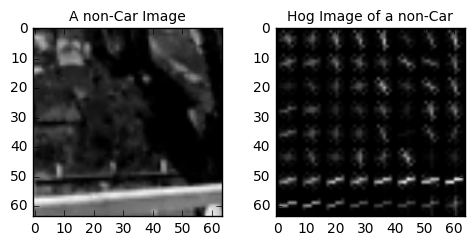

In [9]:
# Generate a random index to look at a notcar image
ind_notcars = np.random.randint(0, len(notcars))
notcar_image = mpimg.imread(notcars[ind_notcars])
gray_image = notcar_image[:,:,2]

feature_vector, hog_image = hog(gray_image, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=True, feature_vector=True)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(5,5))
f.tight_layout()
ax1.imshow(gray_image, cmap = 'gray')
ax1.set_title('A non-Car Image', fontsize = 10)
ax2.imshow(hog_image, cmap = 'gray')
ax2.set_title('Hog Image of a non-Car', fontsize=10)

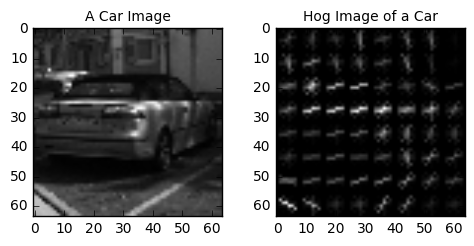

In [10]:
gray_image = car_image[:,:,2]
feature_vector, hog_image = hog(gray_image, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=True, feature_vector=True)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(5,5))
f.tight_layout()
ax1.imshow(gray_image, cmap = 'gray')
ax1.set_title('A Car Image', fontsize = 10)
ax2.imshow(hog_image, cmap = 'gray')
ax2.set_title('Hog Image of a Car', fontsize=10)

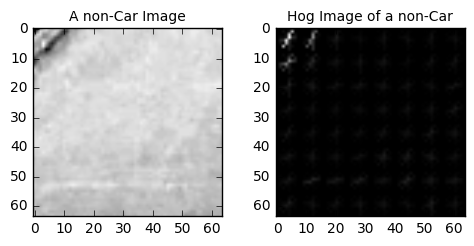

In [11]:
# Generate a random index to look at a notcar image
ind_notcars = np.random.randint(0, len(notcars))
notcar_image = mpimg.imread(notcars[ind_notcars])
gray_image = notcar_image[:,:,2]

feature_vector, hog_image = hog(gray_image, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=True, feature_vector=True)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(5,5))
f.tight_layout()
ax1.imshow(gray_image, cmap = 'gray')
ax1.set_title('A non-Car Image', fontsize = 10)
ax2.imshow(hog_image, cmap = 'gray')
ax2.set_title('Hog Image of a non-Car', fontsize=10)